# Measuring machine learning model fairness using AIF360 fairness metrics

This notebook should be run in a Watson Studio project, using the **Default Spark Python 3.6** runtime environment. **If you are viewing this in Watson Studio and do not see `Python 3.6 with Spark` in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following Cloud services:
  * Watson Machine Learning
  
The notebook will train, create and deploy a German Credit Risk model, and measure the fairness of the model using AIF360 fairness metrics.
   * https://aif360.mybluemix.net

## Test Spark

In [56]:
try:
    from pyspark.sql import SparkSession
except:
    print('Error: Spark runtime is missing. If you are using Watson Studio change the notebook runtime to Spark.')
    raise

## Package installation
### If the testing of spark session failed, then run the below step of installing the required packages and restart the kernel.

In [2]:
!rm -rf $PIP_BUILD
!pip install --upgrade pyspark==2.3 --no-cache | tail -n 1
!pip install --upgrade psycopg2-binary --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1
!pip install --upgrade aif360 --no-cache | tail -n 1

Requirement already up-to-date: numpy in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.17.4)
ERROR: autoai-libs 1.10.3 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.


# Provision services and configure credentials

You will need credentials for Watson Machine Learning. If you already have a WML instance, you may use credentials for it. To provision a new Lite instance of WML, use the [IBM Cloud catalog](https://cloud.ibm.com/catalog/services/machine-learning):  
* Give your service a name, and click **Create**.  
* Once your instance is created, click the **Service Credentials** link on the left side of the screen.  
* Click the **New credential** button, give your credentials a name, and click **Add**.  
* Your new credentials can be accessed by clicking the **View credentials** button.  
* Copy and paste your WML credentials into the cell below.

In [3]:
WML_CREDENTIALS = {
  "apikey": "JS1k7veBHCd0sp_xxxxxxxxxxxxx",
  "iam_apikey_description": "Auto-generated for key 24a63085-xxxxxxxxxxxxx",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/xxxxxxxxxxxxx::serviceid:ServiceId-7cae910a-291c-42cb-xxxxxxxxxxxxx",
  "instance_id": "3e6dc383-581d-4c97-xxxxxxxxxxxxx",
  "url": "https://us-south.ml.cloud.ibm.com"
}

# Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

## Load the training data from github

In [4]:
!rm german_credit_data_biased_training.csv
#!wget https://raw.githubusercontent.com/ravichamarthy/german-credit/master/credit_risk_training_modified.csv
#!wget https://raw.githubusercontent.com/IBM/monitor-wml-model-with-watson-openscale/master/data/german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/ravichamarthy/german-credit/master/credit_risk_training_modified_1711.csv

rm: cannot remove ‘german_credit_data_biased_training.csv’: No such file or directory
--2019-11-23 12:31:08--  https://raw.githubusercontent.com/ravichamarthy/german-credit/master/credit_risk_training_modified_1711.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947513 (925K) [text/plain]
Saving to: ‘credit_risk_training_modified_1711.csv’

100%[======================================>] 947,513     --.-K/s   in 0.04s   

2019-11-23 12:31:09 (23.4 MB/s) - ‘credit_risk_training_modified_1711.csv’ saved [947513/947513]



In [5]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("credit_risk_training_modified_1711.csv", sep=",", header=0)
df_data = spark.read.csv(path="credit_risk_training_modified_1711.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='less_0', LoanDuration=15, CreditHistory='prior_payments_delayed', LoanPurpose='furniture', LoanAmount=250, ExistingSavings='less_100', EmploymentDuration='1_to_4', InstallmentPercent=2, Sex='male', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='real_estate', Age=28, InstallmentPlans='none', Housing='own', ExistingCreditsCount=2, Job='skilled', Dependents=1, Telephone='yes', ForeignWorker='no', Risk='No Risk')

## Explore data
### Print the schema of the training to know what are all the attributes on which we can potentially create and train the model

In [6]:
df_data.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [7]:
print("Number of records: " + str(df_data.count()))

Number of records: 6884


### Find out the different distributions in the training data

In [8]:
# feature on which we want to check the fairness
feature = 'Sex'

# the favorable prediction value
favorable = 'No Risk'

# the unfavorable prediction value
unfavorable = 'Risk'

# the unprivileged/minority group
minority = 'female'

# the privileged/majority group
majority = 'male'

In [9]:
def get_data_distribution(df, label):
    # the favorable data frame
    favorable_df = df.loc[df[label] == favorable]

    # the unfavorable data frame
    unfavorable_df = df.loc[df[label] == unfavorable]

    # the filtered minority data frame
    minority_df = df.loc[df[feature] == minority]

    # the filtered majority data frame
    majority_df = df.loc[df[feature] == majority]

    # the filtered data frame comprising of majority population getting favorable values
    minority_favorable_df = favorable_df.loc[df[feature] == minority]

    # the filtered data frame comprising of majority population getting favorable values
    majority_favorable_df = favorable_df.loc[df[feature] == majority]

    # the filtered data frame comprising of minority population getting unfavorable values
    minority_unfavorable_df = unfavorable_df.loc[df[feature] == minority]

    # the filtered data frame comprising of majority population getting unfavorable values
    majority_unfavorable_df = unfavorable_df.loc[df[feature] == majority]

    # find the rate at which minority population received favorable outcome
    favorable_minority_rate = len(minority_favorable_df) / len(minority_df)

    # find the rate at which majority population received favorable outcome
    favorable_majority_rate = len(majority_favorable_df) / len(majority_df)
    
    return minority_df, majority_df, minority_favorable_df, majority_favorable_df, minority_unfavorable_df, majority_unfavorable_df, favorable_minority_rate, favorable_majority_rate


In [10]:
# the label column
label = 'Risk'

minority_df, majority_df, minority_favorable_df, majority_favorable_df, minority_unfavorable_df, majority_unfavorable_df, \
favorable_minority_rate, favorable_majority_rate = get_data_distribution(pd_data, label)

# calculate the disparate impact ratio
di_value = favorable_minority_rate / favorable_majority_rate

# calculate the statistical parity differance
spd_value = favorable_minority_rate - favorable_majority_rate

In [11]:
print('Length of the training data frame:' + str(len(pd_data)))

print('Number of minorities/unprivileged population (' + str(minority) + ') :' + str(len(minority_df)))
print('Number of majorities/privilaged population (' + str(majority) + ') :' + str(len(majority_df)))
print('Number of minorities with favorable outcomes (' + str(minority) + ') :' + str(len(minority_favorable_df)))
print('Number of majorities with favorable outcomes (' + str(majority) + ') :' + str(len(majority_favorable_df)))
print('Number of minorities with unfavorable outcomes (' + str(minority) + ') :' + str(len(minority_unfavorable_df)))
print('Number of majorities with unfavorable outcomes (' + str(majority) + ') :' + str(len(majority_unfavorable_df)))


print('The disparate impact metric value on the training data:'+str(di_value))
print('The statistical parity difference metric value on the training data:'+str(spd_value))

Length of the training data frame:6884
Number of minorities/unprivileged population (female) :1695
Number of majorities/privilaged population (male) :5189
Number of minorities with favorable outcomes (female) :1414
Number of majorities with favorable outcomes (male) :4800
Number of minorities with unfavorable outcomes (female) :281
Number of majorities with unfavorable outcomes (male) :389
The disparate impact metric value on the training data:0.9018247295968534
The statistical parity difference metric value on the training data:-0.09081543610235177


## Visualize the data distribution
### Plot the distribution for number of minorities and majorities

In [12]:
from matplotlib import pyplot as plt

x_axis = [1, 0]
y_axis = [len(minority_df), len(majority_df)]
x_axis_labels = [minority, majority]

plt.bar(x_axis, y_axis, align='center')
plt.xticks(x_axis, x_axis_labels)
plt.xlabel('Sex')
plt.ylabel('No. of minority/majority values')
plt.title('Minority/Majority distribution')
plt.show()

<Figure size 640x480 with 1 Axes>

### Plot the favorable lables distribution for minorities and majorities

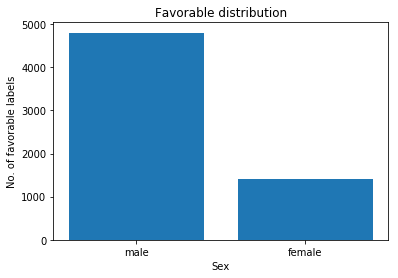

In [13]:
x_axis = [1, 0]
y_axis = [len(minority_favorable_df), len(majority_favorable_df)]
x_axis_labels = [minority, majority]

plt.bar(x_axis, y_axis, align='center')
plt.xticks(x_axis, x_axis_labels)
plt.xlabel('Sex')
plt.ylabel('No. of favorable labels')
plt.title('Favorable distribution')
plt.show()

### Plot the unfavorable lables distribution for minorities and majorities

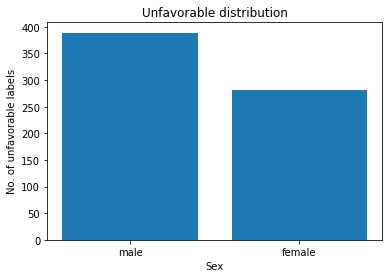

In [14]:
x_axis = [1, 0]
y_axis = [len(minority_unfavorable_df), len(majority_unfavorable_df)]
x_axis_labels = [minority, majority]

plt.bar(x_axis, y_axis, align='center')
plt.xticks(x_axis, x_axis_labels)
plt.xlabel('Sex')
plt.ylabel('No. of unfavorable labels')
plt.title('Unfavorable distribution')
plt.show()

# Create the model

In [15]:
# train test split step
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Spark German Risk Model - Final"
DEPLOYMENT_NAME = "Spark German Risk Deployment - Final"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

spark_df.printSchema()

Number of records for training: 5498
Number of records for evaluation: 1386
root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable =

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

# data type conversion that are needed to be created for the Random Forest Classifier
si_CheckingStatus = StringIndexer(inputCol = 'CheckingStatus', outputCol = 'CheckingStatus_IX')
si_CreditHistory = StringIndexer(inputCol = 'CreditHistory', outputCol = 'CreditHistory_IX')
si_LoanPurpose = StringIndexer(inputCol = 'LoanPurpose', outputCol = 'LoanPurpose_IX')
si_ExistingSavings = StringIndexer(inputCol = 'ExistingSavings', outputCol = 'ExistingSavings_IX')
si_EmploymentDuration = StringIndexer(inputCol = 'EmploymentDuration', outputCol = 'EmploymentDuration_IX')
si_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_IX')
si_OthersOnLoan = StringIndexer(inputCol = 'OthersOnLoan', outputCol = 'OthersOnLoan_IX')
si_OwnsProperty = StringIndexer(inputCol = 'OwnsProperty', outputCol = 'OwnsProperty_IX')
si_InstallmentPlans = StringIndexer(inputCol = 'InstallmentPlans', outputCol = 'InstallmentPlans_IX')
si_Housing = StringIndexer(inputCol = 'Housing', outputCol = 'Housing_IX')
si_Job = StringIndexer(inputCol = 'Job', outputCol = 'Job_IX')
si_Telephone = StringIndexer(inputCol = 'Telephone', outputCol = 'Telephone_IX')
si_ForeignWorker = StringIndexer(inputCol = 'ForeignWorker', outputCol = 'ForeignWorker_IX')

In [17]:
si_Label = StringIndexer(inputCol="Risk", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)
va_features = VectorAssembler(inputCols=["CheckingStatus_IX", "CreditHistory_IX", "LoanPurpose_IX", "ExistingSavings_IX", "EmploymentDuration_IX", "Sex_IX", \
                                         "OthersOnLoan_IX", "OwnsProperty_IX", "InstallmentPlans_IX", "Housing_IX", "Job_IX", "Telephone_IX", "ForeignWorker_IX", \
                                         "LoanDuration", "LoanAmount", "InstallmentPercent", "CurrentResidenceDuration", "LoanDuration", "Age", "ExistingCreditsCount", \
                                         "Dependents"], outputCol="features")

In [18]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

# create the Spark ml pipeline with the random forest classifier
pipeline = Pipeline(stages=[si_CheckingStatus, si_CreditHistory, si_EmploymentDuration, si_ExistingSavings, si_ForeignWorker, si_Housing, si_InstallmentPlans, si_Job, si_LoanPurpose, si_OthersOnLoan,\
                               si_OwnsProperty, si_Sex, si_Telephone, si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [19]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.514925


# Save and deploy the model

In [20]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

### Remove existing model and deployment

In [21]:
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

Deleting deployment id 0681c4e6-1d9e-4b8b-9488-47027bda4d42
Deleting model id d12a9e45-6113-4048-a87c-27956edcc314
------------------------------------  -------------------------------------  ------------------------  -----------------
GUID                                  NAME                                   CREATED                   FRAMEWORK
f0dca134-68ba-4bdc-b86e-166f22f5b40b  RC German Credit Risk Model - PreProd  2019-11-19T08:11:33.539Z  mllib-2.3
07666d82-9e1c-4d98-8183-14fa3635013b  GermanCreditRiskModelYPQA              2019-10-27T01:07:39.977Z  mllib-2.3
5ff3338a-b6ea-4788-a848-42c687cddc8f  Home Sale Model hype                   2019-10-20T05:53:40.289Z  scikit-learn-0.20
d75a6bc9-c664-40f0-9cda-2eb8b8939894  Home Sale Model hype                   2019-10-19T16:49:58.344Z  scikit-learn-0.20
d688d485-2b62-4346-80e3-a10ed7c87683  Home Sale Model hype                   2019-10-19T11:30:34.344Z  scikit-learn-0.20
4226c626-fd6d-4685-9b1c-bb6904bbf17c  Home Sale Model hype    

In [22]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "binary",
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "areaUnderROC",
           "value": area_under_curve,
           "threshold": 0.7
        }
    ]
}

In [23]:
wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props, training_data=train_data, pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


In [24]:
model_id

'5ff3338a-b6ea-4788-a848-42c687cddc8f'

In [25]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '494a5b18-e017-4ef4-8ab0-3c3292f3272f' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='08ca211d-887e-4b45-ae93-4b9303850f80'
------------------------------------------------------------------------------------------------


Model id: 494a5b18-e017-4ef4-8ab0-3c3292f3272f
Deployment id: 08ca211d-887e-4b45-ae93-4b9303850f80


### Score the model so we can configure monitors

In [26]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

08ca211d-887e-4b45-ae93-4b9303850f80
https://us-south.ml.cloud.ibm.com/v3/wml_instances/3e6dc383-581d-4c97-8715-a46523f79fb1/deployments/08ca211d-887e-4b45-ae93-4b9303850f80/online


## Score the model

In [27]:
!rm credit_risk_training_age_modified.csv
!wget https://raw.githubusercontent.com/ravichamarthy/german-credit/master/credit_risk_training_age_modified.csv
#!wget https://raw.githubusercontent.com/IBM/monitor-wml-model-with-watson-openscale/master/data/german_credit_data_biased_training.csv

rm: cannot remove ‘credit_risk_training_age_modified.csv’: No such file or directory
--2019-11-23 12:33:05--  https://raw.githubusercontent.com/ravichamarthy/german-credit/master/credit_risk_training_age_modified.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 854709 (835K) [text/plain]
Saving to: ‘credit_risk_training_age_modified.csv’

100%[======================================>] 854,709     --.-K/s   in 0.04s   

2019-11-23 12:33:06 (21.8 MB/s) - ‘credit_risk_training_age_modified.csv’ saved [854709/854709]



In [28]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
#scoring_request_all = pd.read_csv("credit_risk_training_age_modified.csv", sep=",", header=0)
scoring_request_df = pd.read_csv("credit_risk_training_age_modified.csv", sep=",", header=0)
#scoring_request_df = scoring_request_all.sample(frac=0.05)
#scoring_request_df = scoring_request_df.sort_index(axis = 0)
print('scoring_request_df length:'+str(len(scoring_request_df)))
fields = scoring_request_df.columns.tolist()
values = scoring_request_df.values.tolist()

scoring_request_df length:6251


### Create the scoring payload and score against the WML model

In [29]:
fields = scoring_request_df.columns.tolist()
values = scoring_request_df[fields].values.tolist()
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

In [30]:
fields = scoring_response['fields']
values = scoring_response['values']

# create a pandas data frame using the scored response
scoring_response_df = pd.DataFrame(values, columns = fields)

In [31]:
# the label column
label = 'predictedLabel'

scored_minority_df, scored_majority_df, scored_minority_favorable_df, scored_majority_favorable_df, \
scored_minority_unfavorable_df, scored_majority_unfavorable_df, scored_favorable_minority_rate, scored_favorable_majority_rate = get_data_distribution(scoring_response_df, label)

scored_di_value = scored_favorable_minority_rate / scored_favorable_majority_rate
scored_spd_value = scored_favorable_minority_rate - scored_favorable_majority_rate

print('Number of minorities/unprivileged population in scored data(' + str(minority) + ') :' + str(len(scored_minority_df)))
print('Number of majorities/privilaged population in scored data(' + str(majority) + ') :' + str(len(scored_majority_df)))
print('Number of minorities with favorable outcomes in scored data(' + str(minority) + ') :' + str(len(scored_minority_favorable_df)))
print('Number of majorities with favorable outcomes in scored data(' + str(majority) + ') :' + str(len(scored_majority_favorable_df)))
print('Number of minorities with unfavorable outcomes in scored data(' + str(minority) + ') :' + str(len(scored_minority_unfavorable_df)))
print('Number of majorities with unfavorable outcomes in scored data(' + str(majority) + ') :' + str(len(scored_majority_unfavorable_df)))


print('The disparate impact metric value on the scored data:'+str(scored_di_value))
print('The statistical parity difference metric value on the scored data:'+str(scored_spd_value))

Number of minorities/unprivileged population in scored data(female) :1695
Number of majorities/privilaged population in scored data(male) :4556
Number of minorities with favorable outcomes in scored data(female) :1659
Number of majorities with favorable outcomes in scored data(male) :4556
Number of minorities with unfavorable outcomes in scored data(female) :36
Number of majorities with unfavorable outcomes in scored data(male) :0
The disparate impact metric value on the scored data:0.9787610619469026
The statistical parity difference metric value on the scored data:-0.0212389380530974


### Plot the favorable prediction values in the scored outcome

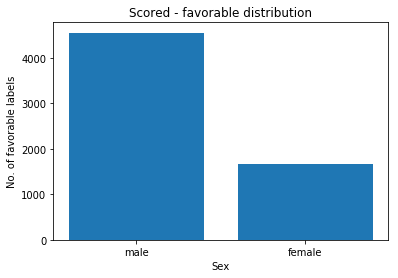

In [32]:
scored_x_axis = [1, 0]
scored_y_axis = [len(scored_minority_favorable_df), len(scored_majority_favorable_df)]
scored_x_axis_labels = [minority, majority]

plt.bar(scored_x_axis, scored_y_axis, align='center')
plt.xticks(scored_x_axis, scored_x_axis_labels)
plt.xlabel('Sex')
plt.ylabel('No. of favorable labels')
plt.title('Scored - favorable distribution')
plt.show()

### Plot the favorable values in the training data - for reference

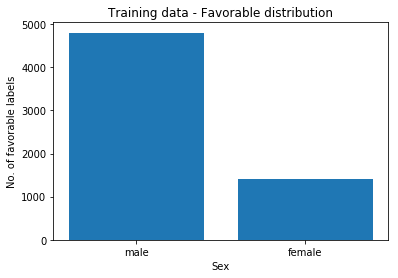

In [33]:
x_axis = [1, 0]
y_axis = [len(minority_favorable_df), len(majority_favorable_df)]
x_axis_labels = [minority, majority]

plt.bar(x_axis, y_axis, align='center')
plt.xticks(x_axis, x_axis_labels)
plt.xlabel('Sex')
plt.ylabel('No. of favorable labels')
plt.title('Training data - Favorable distribution')
plt.show()

#### As you can see the model is predicting good outcomes and spread correctly to both the population groups. What we have done till here is manually finding out the rate of the favorable outcomes for both the groups. In the next series of sections, we shall make use of the IBM’s AIF360 fairness toolkit and try to measure the fairness between both the unprivileged and privileged groups.

In [34]:
# AIF360 requirement - Values should be preprocessed to remove NAs and make all data numerical.
sex_map = {'male': 0.0, 'female': 1.0}
labels_map = {'No Risk': 0.0, 'Risk': 1.0}
scoring_request_df['Sex'] = scoring_request_df['Sex'].replace(sex_map)
scoring_request_df['Risk'] = scoring_request_df['Risk'].replace(labels_map)

# Input DataFrame with features, labels, and protected attributes.
scoring_request_df = scoring_request_df[['Sex','Risk']]

In [35]:
# AIF360 imports
from aif360.datasets import BinaryLabelDataset as BLD
from aif360.datasets import StandardDataset as STD
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

In [36]:
# create a binary label data set with following attributes:
## encoded favorable (No Risk) value: 0.0
## encoded unfavorable (Risk) value: 1.0
## the binary data frame comprising of the feature and the label values: scoring_request_df
## label_names: Risk column
## protected_attribute_names: Sex column
## privileged_protected_attributes: encoded value for males: 0.0

dataset = BLD(favorable_label=0., unfavorable_label=1., df=scoring_request_df,
              label_names=["Risk"], protected_attribute_names=["Sex"], 
              privileged_protected_attributes=[0.0])

# create another binary data set with additional columns containing the model predicted values - prediction and probability
dataset_pred = dataset.copy(deepcopy=True)
dataset_pred.scores = scoring_response_df['probability']
dataset_pred.labels = scoring_response_df['prediction']

# encode the unprivilage and privilage groups
unprivileged_groups = [{'Sex': 1.0}]
privileged_groups = [{'Sex': 0.0}]

# Now create an Classification Metric with the labeled data set and the predicted values based data set. Also mention what are the privilaged and unprivileged groups.
cm = ClassificationMetric (dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

In [47]:
# What is the difference in favorable outcomes between males (privilaged) and feamles (unprivilaged) groups?
# When that difference is small or close to zero, the classifier is said to have “statistical parity” (statistically fair to both the groups).
# In this example, the statistical parity difference value is -0.0165, which means that male population have received a slightly (by a factor of 0.0165) favorable outcomes when compared to females.
statistical_parity_difference = cm.statistical_parity_difference()
print(statistical_parity_difference)

-0.0212389380530974


In [48]:
disparate_impact = cm.disparate_impact()
print(disparate_impact)

0.9787610619469026


In [49]:
between_all_groups_generalized_entropy_index = cm.between_all_groups_generalized_entropy_index(alpha=2)
print(between_all_groups_generalized_entropy_index)

0.001935845727733805


In [50]:
between_group_generalized_entropy_index = cm.between_group_generalized_entropy_index(alpha=2)
print(between_group_generalized_entropy_index)

0.001935845727733805


In [51]:
between_group_theil_index = cm.between_group_theil_index()
print(between_group_theil_index)

0.0018969443963106902


In [52]:
between_all_groups_theil_index = cm.between_all_groups_theil_index()
print(between_all_groups_theil_index)

0.0018969443963106902


In [53]:
between_group_coefficient_of_variation = cm.between_group_coefficient_of_variation()
print(between_group_coefficient_of_variation)

0.08799649374228055


In [54]:
between_all_groups_coefficient_of_variation = cm.between_all_groups_coefficient_of_variation()
print(between_all_groups_coefficient_of_variation)

0.08799649374228055


In [55]:
generalized_entropy_index = cm.generalized_entropy_index(2)
print(generalized_entropy_index)

0.06034196094725056
